Import

In [1]:
from PIL import Image, ImageEnhance, ImageFilter
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score

import shutil

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
!curl -L -o Font_recognition.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Workshop/Font_recognition.zip
!unzip -o  /content/Font_recognition.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: images/9ac8a008-12f8-4eb9-a4ef-c2f2d78ccc4e.jpg  
  inflating: images/9adb4195-2a08-4a72-800b-0ceccdd92c56.jpg  
  inflating: images/9ae5ebcc-b744-458c-8ebc-c0bb00ded94a.jpg  
  inflating: images/9ae7c34f-e754-430a-af69-a269c82e0185.jpg  
  inflating: images/9aefd856-6027-4524-bf6b-585aaffc4f64.jpg  
  inflating: images/9af13c53-91e7-4dda-b880-f3d3fa0c3cc2.jpg  
  inflating: images/9afb1f5b-b579-4ea3-b6a8-11afe99c2ac0.jpg  
  inflating: images/9aff54d3-8d05-40e2-9961-0e497fdee70d.jpg  
  inflating: images/9b001318-5721-489f-956d-127dc01c4aba.jpg  
  inflating: images/9b116749-3595-40d6-b592-e78a8d534295.jpg  
  inflating: images/9b12ef52-33f7-431d-83a2-2b7ee3d55e76.jpg  
  inflating: images/9b157027-bb83-40c1-b61b-8bcce87a8c9b.jpg  
  inflating: images/9b1b93f3-4486-4f81-bc9c-22dc7e618e6f.jpg  
  inflating: images/9b1e81ed-04f0-4180-8ef3-051c94f64739.jpg  
  inflating: images/9b1f0e9e-db1c-48dd-835f-c61b1951a4b2.jpg 

In [3]:
def process_csv(csv_path, images_folder, output_base_folder, has_labels=False):
    df = pd.read_csv(csv_path)

    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    for index, row in df.iterrows():
        image_path = row['image_path']
        if has_labels:
            font = row.get('font', 'unknown_font')
            font_size = row.get('font_size', 'unknown_size')
            color = row.get('color', 'unknown_color').replace("#", "")

            class_folder = os.path.join(
                output_base_folder,
                color,
                font,
                f"size_{font_size}"
            )
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
        else:
            class_folder = output_base_folder

        source = os.path.join(images_folder, os.path.basename(image_path))
        destination = os.path.join(class_folder, os.path.basename(image_path))

        if os.path.exists(source):
            shutil.copy2(source, destination)
        else:
            print(f"File {os.path.basename(image_path)} does not exist in {images_folder}")

train_csv_path = '/content/train.csv'
test_csv_path = '/content/test.csv'
images_folder = '/content/images'

train_output_base_folder = '/content/train'
test_output_base_folder = '/content/test'

process_csv(train_csv_path, images_folder, train_output_base_folder, has_labels=True)
process_csv(test_csv_path, images_folder, test_output_base_folder, has_labels=False)

In [28]:
class MultiAlphabetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        self.color_mapping = {'FF6666': 0, '0000FF': 1, 'A020F0': 2, 'DF3030': 3, '26E953': 4}
        self.font_mapping = {'Athiti-Regular': 0, 'Sarabun-Regular': 1, 'NotoSerifThai-Regular': 2,
                             'Kodchasan-Regular': 3, 'Prompt-Regular': 4, 'KhaosuayThin': 5, 'FkBeautyRegular': 6}
        self.font_size_mapping = {18: 0, 20: 1, 22: 2, 24: 3, 26: 4, 28: 5}

        for color_dir in os.scandir(root_dir):
            if color_dir.is_dir():
                color = color_dir.name
                for font_dir in os.scandir(color_dir.path):
                    if font_dir.is_dir():
                        font = font_dir.name
                        for size_dir in os.scandir(font_dir.path):
                            if size_dir.is_dir() and size_dir.name.startswith("size_"):
                                font_size = int(size_dir.name.split('_')[1])
                                for file in os.scandir(size_dir.path):
                                    if file.is_file():
                                        self.samples.append((file.path, font, font_size, color))

        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, font, font_size, color = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Encode labels as tensors
        font_encoded = torch.tensor(self.font_mapping.get(font), dtype=torch.long)
        font_size_encoded = torch.tensor(self.font_size_mapping.get(font_size), dtype=torch.long)
        color_encoded = torch.tensor(self.color_mapping.get(color), dtype=torch.long)

        return image, color_encoded, font_encoded, font_size_encoded

In [29]:
class ReverseIntensity:
  def __init__(self, threshold=150):
    self.threshold = threshold

  def __call__(self, image):

    if isinstance(image, Image.Image):
      image_np = np.array(image)
    elif isinstance(image, np.ndarray):
      image_np = image
    else:
      raise TypeError("Unsupported type. Expected PIL Image or numpy array.")

    if np.mean(image_np) > self.threshold:
      reversed_image = 255 - image_np
      return Image. fromarray(reversed_image)
    else:
      return image

fillter

In [30]:
class Sharpen(object):
    def __call__(self, img):
        enhancer = ImageEnhance.Sharpness(img)
        return enhancer.enhance(3.0)

class MedianBlur(object):
    def __init__(self, kernel_size=1):
        self.kernel_size = kernel_size

    def __call__(self, img):
        img = img.filter(ImageFilter.MedianFilter(size=self.kernel_size))
        return img

In [31]:
transform = transforms.Compose([
    transforms.CenterCrop(0),
    transforms.ToTensor()
    ])

root_dir = '/content/train'
dataset = MultiAlphabetDataset(root_dir=root_dir, transform=transform)

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

images, colors, fonts, font_sizes = next(iter(dataloader))

color_names = [reverse_color_mapping[int(color)] for color in colors]
font_names = [reverse_font_mapping[int(font)] for font in fonts]
font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

print(f"Batch Images Shape: {images.shape}")
print(f"Batch Colors: {color_names}")
print(f"Batch Fonts: {font_names}")
print(f"Batch Font Sizes: {font_size_names}")

Total samples found: 10080
Batch Images Shape: torch.Size([4, 3, 0, 0])
Batch Colors: ['DF3030', '0000FF', 'FF6666', 'A020F0']
Batch Fonts: ['NotoSerifThai-Regular', 'FkBeautyRegular', 'Athiti-Regular', 'KhaosuayThin']
Batch Font Sizes: [20, 20, 18, 18]


In [32]:
def load_data(reverse=False, normalize=False, batch_size=32):
    root_dir = '/content/train'

    train_transform = transforms.Compose([
          transforms.RandomAffine(degrees=(0),translate=(0.05, 0.05)),
          transforms.CenterCrop( (40,360)),
          MedianBlur(kernel_size=1),
          Sharpen(),
          transforms.ColorJitter(contrast=0.1),
          transforms.ToTensor(),
          ])

    dataset = MultiAlphabetDataset(root_dir=root_dir, transform=train_transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader
train_loader, test_loader = load_data(reverse=False, normalize=False, batch_size=32)

Total samples found: 10080


In [60]:
def get_dataset_stats(loader):
    font_count = {}
    font_size_count = {}
    color_count = {}
    total_samples = 0

    reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
    reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
    reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

    for batch in loader:
        images, colors, fonts, font_sizes = batch

        color_names = [reverse_color_mapping[int(color)] for color in colors]
        font_names = [reverse_font_mapping[int(font)] for font in fonts]
        font_size_names = [reverse_font_size_mapping[int(font_size)] for font_size in font_sizes]

        for color in color_names:
            if color not in color_count:
                color_count[color] = 0
            color_count[color] += 1

        for font in font_names:
            if font not in font_count:
                font_count[font] = 0
            font_count[font] += 1

        for font_size in font_size_names:
            if font_size not in font_size_count:
                font_size_count[font_size] = 0
            font_size_count[font_size] += 1

        total_samples += len(images)

    return font_count, font_size_count, color_count, total_samples

In [63]:
train_font_count, train_font_size_count, train_color_count, train_total_samples = get_dataset_stats(train_loader)
test_font_count, test_font_size_count, test_color_count, test_total_samples = get_dataset_stats(test_loader)

print("Train")
for font, count in train_font_count.items():
    print(f"\tfont {font} : {count}")
for font_size, count in train_font_size_count.items():
    print(f"\tfont size {font_size} : {count}")
for color, count in train_color_count.items():
    print(f"\tcolor {color} : {count}")
print(f"\tAll: {train_total_samples}")

print("Test")
for font, count in test_font_count.items():
    print(f"\tfont {font} : {count}")
for font_size, count in test_font_size_count.items():
    print(f"\tfont size {font_size} : {count}")
for color, count in test_color_count.items():
    print(f"\tcolor {color} : {count}")
print(f"\tAll : {test_total_samples}")

Train
	font Athiti-Regular : 1117
	font KhaosuayThin : 1169
	font FkBeautyRegular : 1174
	font Kodchasan-Regular : 1157
	font Prompt-Regular : 1147
	font NotoSerifThai-Regular : 1149
	font Sarabun-Regular : 1151
	font size 20 : 1365
	font size 22 : 1343
	font size 26 : 1358
	font size 18 : 1341
	font size 28 : 1338
	font size 24 : 1319
	color 26E953 : 1610
	color DF3030 : 1634
	color A020F0 : 1625
	color FF6666 : 1622
	color 0000FF : 1573
	All: 8064
Test
	font Prompt-Regular : 293
	font Athiti-Regular : 323
	font Kodchasan-Regular : 283
	font Sarabun-Regular : 289
	font NotoSerifThai-Regular : 291
	font FkBeautyRegular : 266
	font KhaosuayThin : 271
	font size 26 : 322
	font size 22 : 337
	font size 18 : 339
	font size 24 : 361
	font size 28 : 342
	font size 20 : 315
	color A020F0 : 391
	color DF3030 : 382
	color 0000FF : 443
	color 26E953 : 406
	color FF6666 : 394
	All : 2016


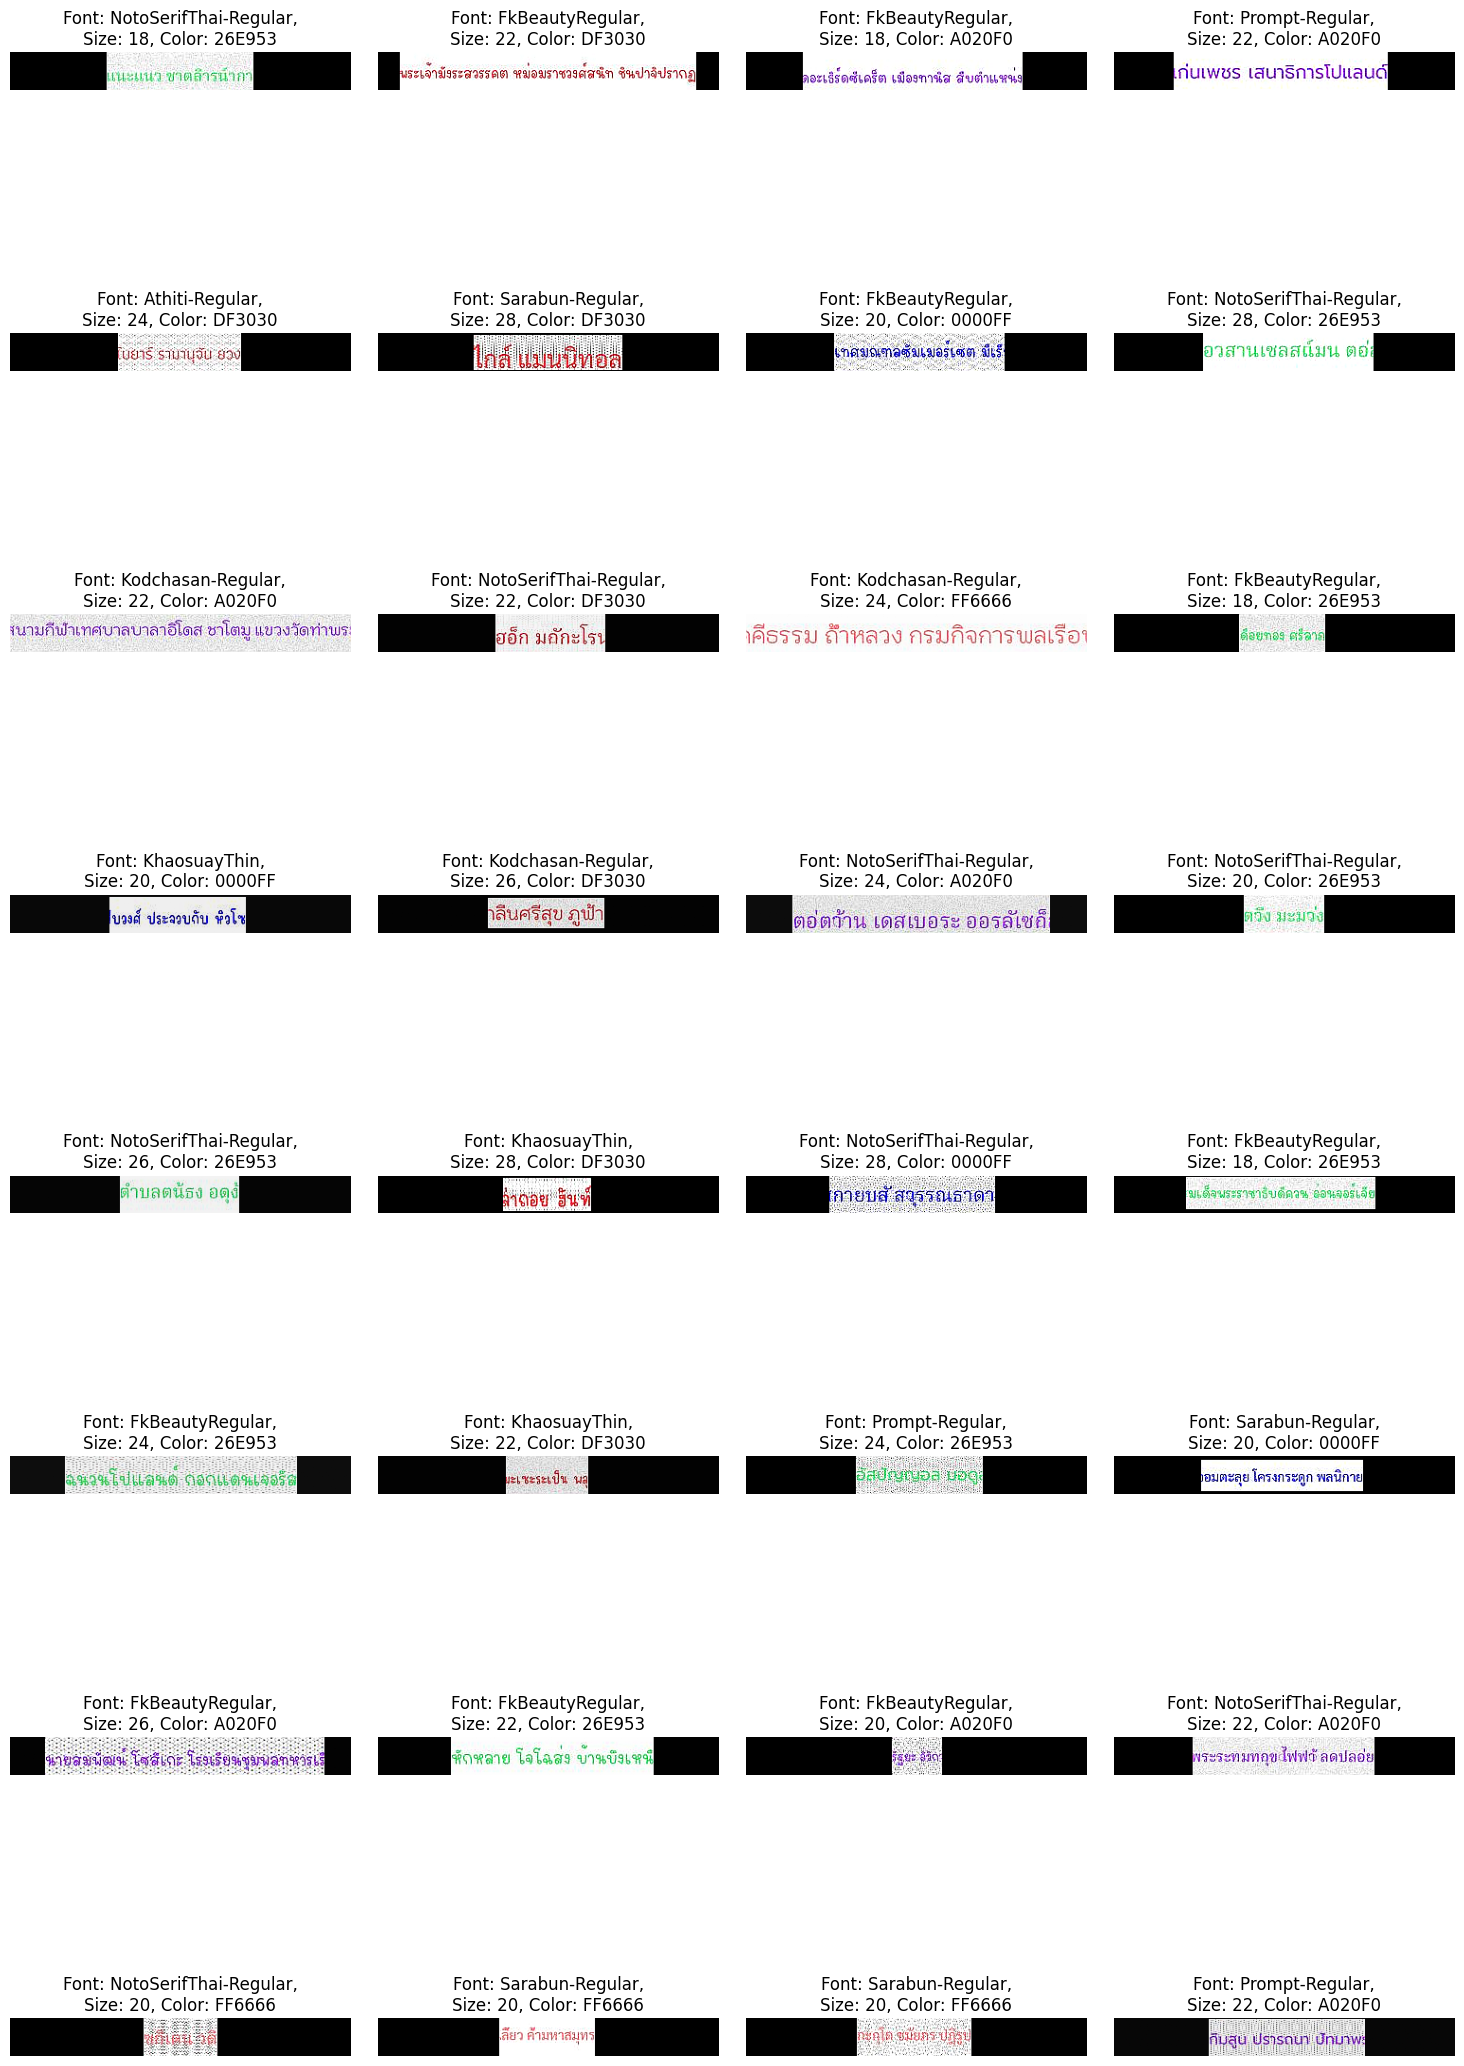

In [33]:
batch_size = 32
images, colors, fonts, font_sizes = next(iter(train_loader))

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

fig, axes = plt.subplots(8, 4, figsize=(15, 24))
axes = axes.flatten()

for idx, (img, color, font, font_size) in enumerate(zip(images[:batch_size], colors[:batch_size], fonts[:batch_size], font_sizes[:batch_size])):
    ax = axes[idx]

    img_np = img.permute(1, 2, 0).numpy()

    color_name = reverse_color_mapping[int(color)]
    font_name = reverse_font_mapping[int(font)]
    font_size_value = reverse_font_size_mapping[int(font_size)]

    ax.imshow(img_np)
    ax.set_title(f"Font: {font_name},\nSize: {font_size_value}, Color: {color_name}")
    ax.axis('off')

for ax in axes[len(images[:batch_size]):]:
    ax.axis('off')

plt.tight_layout(pad=2.0)
plt.show()

In [34]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
class CustomVGG16(nn.Module):
    def __init__(self,
                 num_colors=5,
                 num_fonts=7,
                 num_sizes=6,
                 h_dims_color=[256, 128],
                 h_dims_font=[768, 512, 256],
                 h_dims_size=[1024, 512, 256],
                 input_size=(3, 224, 224)):
        super(CustomVGG16, self).__init__()

        self.vgg16 = models.vgg16(pretrained=True)
        self.vgg16.flatten = nn.Flatten()

        for param in self.vgg16.features.parameters():
            param.requires_grad = True

        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True

        classifier = []
        in_features = self._get_input_size_fc(input_size)

        self.color_classifier = self._create_classifier(in_features, h_dims_color, num_colors)
        self.font_classifier = self._create_classifier(in_features, h_dims_font, num_fonts)
        self.size_classifier = self._create_classifier(in_features, h_dims_size, num_sizes)

    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self.vgg16.features(dummy_input)
            x = self.vgg16.avgpool(x)
            x = self.vgg16.flatten(x)
            return x.shape[-1]

    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.3))
            in_features = hdim
        layers.append(nn.Linear(in_features, num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = self.vgg16.flatten(x)

        color_output = self.color_classifier(x)
        font_output = self.font_classifier(x)
        size_output = self.size_classifier(x)

        return color_output, font_output, size_output

In [35]:
best_score = 0.0
best_epoch = 0
def calculate_fbeta_score(precision, recall, beta):
    beta_squared = beta ** 2
    return (1 + beta_squared) * (precision * recall) / ((beta_squared * precision) + recall + 1e-7)

def train(model,
          optimizer,
          train_loader,
          test_loader,
          epochs=10,
          beta=1,
          checkpoint_path=None,
          device='cpu'):
    global best_score
    model = model.to(device)
    print("🤖 Training on", device)

    for epoch in range(epochs):
        model.train()

        LR = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        cross_entropy_loss = nn.CrossEntropyLoss()

        train_bar = tqdm(train_loader,
                         desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]',
                         unit='batch')

        for batch_idx, (data, color_target, font_target, size_target) in enumerate(train_bar):
            data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

            optimizer.zero_grad()

            color_output, font_output, size_output = model(data)
            loss_color = cross_entropy_loss(color_output, color_target)
            loss_font = cross_entropy_loss(font_output, font_target)
            loss_size = cross_entropy_loss(size_output, size_target)

            loss = loss_color*0.6 + loss_font*1.2 + loss_size*1.6

            loss.backward()
            optimizer.step()

            train_bar.set_postfix(loss=loss.item())

        model.eval()
        LR.step()

        correct_color, correct_font, correct_size = 0, 0, 0
        test_loss_color, test_loss_font, test_loss_size = 0, 0, 0

        all_color_preds, all_color_targets = [], []
        all_font_preds, all_font_targets = [], []
        all_size_preds, all_size_targets = [], []

        with torch.no_grad():
            test_bar = tqdm(test_loader,
                            desc=f"🧪 Testing Epoch [{epoch+1}/{epochs}]",
                            unit='batch')

            for data, color_target, font_target, size_target in test_bar:
                data, color_target, font_target, size_target = data.to(device), color_target.to(device), font_target.to(device), size_target.to(device)

                color_output, font_output, size_output = model(data)

                test_loss_color += cross_entropy_loss(color_output, color_target).item()
                test_loss_font += cross_entropy_loss(font_output, font_target).item()
                test_loss_size += cross_entropy_loss(size_output, size_target).item()

                color_pred = color_output.argmax(dim=1, keepdim=True)
                font_pred = font_output.argmax(dim=1, keepdim=True)
                size_pred = size_output.argmax(dim=1, keepdim=True)

                correct_color += color_pred.eq(color_target.view_as(color_pred)).sum().item()
                correct_font += font_pred.eq(font_target.view_as(font_pred)).sum().item()
                correct_size += size_pred.eq(size_target.view_as(size_pred)).sum().item()

                all_color_preds.extend(color_pred.cpu().numpy())
                all_color_targets.extend(color_target.cpu().numpy())
                all_font_preds.extend(font_pred.cpu().numpy())
                all_font_targets.extend(font_target.cpu().numpy())
                all_size_preds.extend(size_pred.cpu().numpy())
                all_size_targets.extend(size_target.cpu().numpy())

            test_loss_color /= len(test_loader.dataset)
            test_loss_font /= len(test_loader.dataset)
            test_loss_size /= len(test_loader.dataset)

            precision_color = precision_score(all_color_targets, all_color_preds, average='weighted')
            recall_color = recall_score(all_color_targets, all_color_preds, average='weighted')
            precision_font = precision_score(all_font_targets, all_font_preds, average='weighted')
            recall_font = recall_score(all_font_targets, all_font_preds, average='weighted')
            precision_size = precision_score(all_size_targets, all_size_preds, average='weighted')
            recall_size = recall_score(all_size_targets, all_size_preds, average='weighted')

            fbeta_color = calculate_fbeta_score(precision_color, recall_color, beta)
            fbeta_font = calculate_fbeta_score(precision_font, recall_font, beta)
            fbeta_size = calculate_fbeta_score(precision_size, recall_size, beta)

            fbeta_total = (fbeta_font * 0.3) + (fbeta_color * 0.2) + (fbeta_size * 0.5)
            print("-----------------------------------------------------------------------------------------------------")
            print(f'Color loss: {test_loss_color:.4f},🟩 fbeta% : {100*fbeta_color:.2f}%')
            print(f'loss: {test_loss_font:.4f},🟧 fbeta% : {100*fbeta_font:.2f}%')
            print(f'loss: {test_loss_size:.4f},🟥 fbeta% : {100*fbeta_size:.2f}%')
            print(f'🆘 Total F-beta) : {fbeta_total:.4f}')

            if fbeta_total > best_score:
                best_score = fbeta_total
                best_epoch = epoch + 1
                if checkpoint_path:
                    torch.save(model.state_dict(), checkpoint_path)
                    print(f'# 🧱 Saved checkpoint at : {fbeta_total:.4f} at epoch {epoch+1} 🧱')

In [36]:
model = CustomVGG16(h_dims_color=[256, 128], h_dims_font=[1024, 512, 256],h_dims_size=[3072, 1024, 512])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00008, weight_decay=1e-4)
LR = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=100,
      beta=2,
      checkpoint_path="/content/checkpoint.pth",
      device=device)

print(f"😎 Best Score is {best_score:.4f}")
print(f"😎 Best Epoch at {best_epoch}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


🧪 Testing Epoch [1/100]: 100%|██████████| 63/63 [00:07<00:00,  8.11batch/s]


Test set:
Average Color loss: 0.0020,🟩 fbeta: 98.37%
Average Font loss: 0.0187,🟧 fbeta: 73.29%
Average Size loss: 0.0419,🟥 fbeta: 37.87%
🆘 Real Score (Total F-beta): 0.6060
# 🧱 Best model saved with F-beta Score: 0.6060 at epoch 1 🧱


🧪 Testing Epoch [2/100]: 100%|██████████| 63/63 [00:07<00:00,  8.29batch/s]


Test set:
Average Color loss: 0.0033,🟩 fbeta: 96.45%
Average Font loss: 0.0100,🟧 fbeta: 86.65%
Average Size loss: 0.0353,🟥 fbeta: 49.29%
🆘 Real Score (Total F-beta): 0.6993
# 🧱 Best model saved with F-beta Score: 0.6993 at epoch 2 🧱


🧪 Testing Epoch [3/100]: 100%|██████████| 63/63 [00:08<00:00,  7.02batch/s]


Test set:
Average Color loss: 0.0021,🟩 fbeta: 97.79%
Average Font loss: 0.0091,🟧 fbeta: 88.27%
Average Size loss: 0.0316,🟥 fbeta: 55.45%
🆘 Real Score (Total F-beta): 0.7377
# 🧱 Best model saved with F-beta Score: 0.7377 at epoch 3 🧱


🧪 Testing Epoch [4/100]: 100%|██████████| 63/63 [00:08<00:00,  7.68batch/s]


Test set:
Average Color loss: 0.0011,🟩 fbeta: 98.96%
Average Font loss: 0.0045,🟧 fbeta: 95.42%
Average Size loss: 0.0269,🟥 fbeta: 63.28%
🆘 Real Score (Total F-beta): 0.8006
# 🧱 Best model saved with F-beta Score: 0.8006 at epoch 4 🧱


🧪 Testing Epoch [5/100]: 100%|██████████| 63/63 [00:07<00:00,  8.26batch/s]


Test set:
Average Color loss: 0.0007,🟩 fbeta: 99.36%
Average Font loss: 0.0048,🟧 fbeta: 94.82%
Average Size loss: 0.0247,🟥 fbeta: 64.79%
🆘 Real Score (Total F-beta): 0.8071
# 🧱 Best model saved with F-beta Score: 0.8071 at epoch 5 🧱


🧪 Testing Epoch [6/100]: 100%|██████████| 63/63 [00:08<00:00,  7.68batch/s]


Test set:
Average Color loss: 0.0007,🟩 fbeta: 99.36%
Average Font loss: 0.0098,🟧 fbeta: 90.34%
Average Size loss: 0.0233,🟥 fbeta: 67.63%
🆘 Real Score (Total F-beta): 0.8079
# 🧱 Best model saved with F-beta Score: 0.8079 at epoch 6 🧱


🧪 Testing Epoch [7/100]: 100%|██████████| 63/63 [00:07<00:00,  8.25batch/s]


Test set:
Average Color loss: 0.0011,🟩 fbeta: 98.76%
Average Font loss: 0.0081,🟧 fbeta: 91.11%
Average Size loss: 0.0219,🟥 fbeta: 70.76%
🆘 Real Score (Total F-beta): 0.8246
# 🧱 Best model saved with F-beta Score: 0.8246 at epoch 7 🧱


🧪 Testing Epoch [8/100]: 100%|██████████| 63/63 [00:08<00:00,  7.41batch/s]


Test set:
Average Color loss: 0.0060,🟩 fbeta: 94.50%
Average Font loss: 0.0039,🟧 fbeta: 95.70%
Average Size loss: 0.0211,🟥 fbeta: 70.93%
🆘 Real Score (Total F-beta): 0.8308
# 🧱 Best model saved with F-beta Score: 0.8308 at epoch 8 🧱


🧪 Testing Epoch [9/100]: 100%|██████████| 63/63 [00:08<00:00,  7.34batch/s]


Test set:
Average Color loss: 0.0010,🟩 fbeta: 98.96%
Average Font loss: 0.0023,🟧 fbeta: 97.53%
Average Size loss: 0.0183,🟥 fbeta: 77.77%
🆘 Real Score (Total F-beta): 0.8794
# 🧱 Best model saved with F-beta Score: 0.8794 at epoch 9 🧱


🧪 Testing Epoch [10/100]: 100%|██████████| 63/63 [00:08<00:00,  7.08batch/s]


Test set:
Average Color loss: 0.0010,🟩 fbeta: 99.26%
Average Font loss: 0.0023,🟧 fbeta: 97.28%
Average Size loss: 0.0208,🟥 fbeta: 75.93%
🆘 Real Score (Total F-beta): 0.8700


🧪 Testing Epoch [11/100]: 100%|██████████| 63/63 [00:08<00:00,  7.48batch/s]


Test set:
Average Color loss: 0.0011,🟩 fbeta: 98.77%
Average Font loss: 0.0022,🟧 fbeta: 97.28%
Average Size loss: 0.0176,🟥 fbeta: 79.96%
🆘 Real Score (Total F-beta): 0.8891
# 🧱 Best model saved with F-beta Score: 0.8891 at epoch 11 🧱


🧪 Testing Epoch [12/100]: 100%|██████████| 63/63 [00:07<00:00,  8.30batch/s]


Test set:
Average Color loss: 0.0004,🟩 fbeta: 99.56%
Average Font loss: 0.0026,🟧 fbeta: 97.38%
Average Size loss: 0.0170,🟥 fbeta: 79.72%
🆘 Real Score (Total F-beta): 0.8899
# 🧱 Best model saved with F-beta Score: 0.8899 at epoch 12 🧱


🧪 Testing Epoch [13/100]: 100%|██████████| 63/63 [00:08<00:00,  7.08batch/s]


Test set:
Average Color loss: 0.0009,🟩 fbeta: 99.11%
Average Font loss: 0.0022,🟧 fbeta: 97.44%
Average Size loss: 0.0185,🟥 fbeta: 79.47%
🆘 Real Score (Total F-beta): 0.8879


🧪 Testing Epoch [14/100]: 100%|██████████| 63/63 [00:08<00:00,  7.80batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.65%
Average Font loss: 0.0050,🟧 fbeta: 95.37%
Average Size loss: 0.0250,🟥 fbeta: 73.37%
🆘 Real Score (Total F-beta): 0.8523


🧪 Testing Epoch [15/100]: 100%|██████████| 63/63 [00:10<00:00,  5.99batch/s]


Test set:
Average Color loss: 0.0009,🟩 fbeta: 99.01%
Average Font loss: 0.0045,🟧 fbeta: 95.15%
Average Size loss: 0.0182,🟥 fbeta: 79.01%
🆘 Real Score (Total F-beta): 0.8785


🧪 Testing Epoch [16/100]: 100%|██████████| 63/63 [00:09<00:00,  6.97batch/s]


Test set:
Average Color loss: 0.0009,🟩 fbeta: 98.96%
Average Font loss: 0.0023,🟧 fbeta: 97.29%
Average Size loss: 0.0167,🟥 fbeta: 80.39%
🆘 Real Score (Total F-beta): 0.8917
# 🧱 Best model saved with F-beta Score: 0.8917 at epoch 16 🧱


🧪 Testing Epoch [17/100]: 100%|██████████| 63/63 [00:08<00:00,  7.56batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.80%
Average Font loss: 0.0020,🟧 fbeta: 98.12%
Average Size loss: 0.0177,🟥 fbeta: 79.85%
🆘 Real Score (Total F-beta): 0.8932
# 🧱 Best model saved with F-beta Score: 0.8932 at epoch 17 🧱


🧪 Testing Epoch [18/100]: 100%|██████████| 63/63 [00:08<00:00,  7.14batch/s]


Test set:
Average Color loss: 0.0033,🟩 fbeta: 97.74%
Average Font loss: 0.0019,🟧 fbeta: 98.22%
Average Size loss: 0.0171,🟥 fbeta: 82.02%
🆘 Real Score (Total F-beta): 0.9002
# 🧱 Best model saved with F-beta Score: 0.9002 at epoch 18 🧱


🧪 Testing Epoch [19/100]: 100%|██████████| 63/63 [00:08<00:00,  7.31batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.55%
Average Font loss: 0.0021,🟧 fbeta: 97.77%
Average Size loss: 0.0176,🟥 fbeta: 82.06%
🆘 Real Score (Total F-beta): 0.9027
# 🧱 Best model saved with F-beta Score: 0.9027 at epoch 19 🧱


🧪 Testing Epoch [20/100]: 100%|██████████| 63/63 [00:08<00:00,  7.69batch/s]


Test set:
Average Color loss: 0.0007,🟩 fbeta: 99.45%
Average Font loss: 0.0039,🟧 fbeta: 96.17%
Average Size loss: 0.0329,🟥 fbeta: 68.95%
🆘 Real Score (Total F-beta): 0.8322


🧪 Testing Epoch [21/100]: 100%|██████████| 63/63 [00:08<00:00,  7.57batch/s]


Test set:
Average Color loss: 0.0009,🟩 fbeta: 99.16%
Average Font loss: 0.0027,🟧 fbeta: 97.15%
Average Size loss: 0.0146,🟥 fbeta: 83.38%
🆘 Real Score (Total F-beta): 0.9067
# 🧱 Best model saved with F-beta Score: 0.9067 at epoch 21 🧱


🧪 Testing Epoch [22/100]: 100%|██████████| 63/63 [00:09<00:00,  6.55batch/s]


Test set:
Average Color loss: 0.0012,🟩 fbeta: 99.06%
Average Font loss: 0.0045,🟧 fbeta: 96.62%
Average Size loss: 0.0155,🟥 fbeta: 83.47%
🆘 Real Score (Total F-beta): 0.9053


🧪 Testing Epoch [23/100]: 100%|██████████| 63/63 [00:07<00:00,  8.30batch/s]


Test set:
Average Color loss: 0.0004,🟩 fbeta: 99.60%
Average Font loss: 0.0044,🟧 fbeta: 96.24%
Average Size loss: 0.0167,🟥 fbeta: 83.76%
🆘 Real Score (Total F-beta): 0.9068
# 🧱 Best model saved with F-beta Score: 0.9068 at epoch 23 🧱


🧪 Testing Epoch [24/100]: 100%|██████████| 63/63 [00:07<00:00,  8.24batch/s]


Test set:
Average Color loss: 0.0005,🟩 fbeta: 99.45%
Average Font loss: 0.0037,🟧 fbeta: 96.79%
Average Size loss: 0.0166,🟥 fbeta: 82.40%
🆘 Real Score (Total F-beta): 0.9013


🧪 Testing Epoch [25/100]: 100%|██████████| 63/63 [00:07<00:00,  8.12batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.75%
Average Font loss: 0.0028,🟧 fbeta: 96.91%
Average Size loss: 0.0184,🟥 fbeta: 81.63%
🆘 Real Score (Total F-beta): 0.8984


🧪 Testing Epoch [26/100]: 100%|██████████| 63/63 [00:09<00:00,  6.87batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.75%
Average Font loss: 0.0034,🟧 fbeta: 96.99%
Average Size loss: 0.0161,🟥 fbeta: 84.30%
🆘 Real Score (Total F-beta): 0.9120
# 🧱 Best model saved with F-beta Score: 0.9120 at epoch 26 🧱


🧪 Testing Epoch [27/100]: 100%|██████████| 63/63 [00:08<00:00,  7.10batch/s]


Test set:
Average Color loss: 0.0025,🟩 fbeta: 98.62%
Average Font loss: 0.0044,🟧 fbeta: 95.89%
Average Size loss: 0.0180,🟥 fbeta: 80.43%
🆘 Real Score (Total F-beta): 0.8870


🧪 Testing Epoch [28/100]: 100%|██████████| 63/63 [00:09<00:00,  6.99batch/s]


Test set:
Average Color loss: 0.0008,🟩 fbeta: 99.01%
Average Font loss: 0.0027,🟧 fbeta: 97.53%
Average Size loss: 0.0153,🟥 fbeta: 86.84%
🆘 Real Score (Total F-beta): 0.9248
# 🧱 Best model saved with F-beta Score: 0.9248 at epoch 28 🧱


🧪 Testing Epoch [29/100]: 100%|██████████| 63/63 [00:08<00:00,  7.67batch/s]


Test set:
Average Color loss: 0.0004,🟩 fbeta: 99.60%
Average Font loss: 0.0033,🟧 fbeta: 96.65%
Average Size loss: 0.0137,🟥 fbeta: 86.63%
🆘 Real Score (Total F-beta): 0.9223


🧪 Testing Epoch [30/100]: 100%|██████████| 63/63 [00:07<00:00,  8.17batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.70%
Average Font loss: 0.0016,🟧 fbeta: 98.37%
Average Size loss: 0.0159,🟥 fbeta: 85.78%
🆘 Real Score (Total F-beta): 0.9234


🧪 Testing Epoch [31/100]: 100%|██████████| 63/63 [00:07<00:00,  8.33batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.41%
Average Font loss: 0.0023,🟧 fbeta: 97.74%
Average Size loss: 0.0145,🟥 fbeta: 86.60%
🆘 Real Score (Total F-beta): 0.9250
# 🧱 Best model saved with F-beta Score: 0.9250 at epoch 31 🧱


🧪 Testing Epoch [32/100]: 100%|██████████| 63/63 [00:08<00:00,  7.34batch/s]


Test set:
Average Color loss: 0.0011,🟩 fbeta: 99.21%
Average Font loss: 0.0050,🟧 fbeta: 95.20%
Average Size loss: 0.0140,🟥 fbeta: 85.30%
🆘 Real Score (Total F-beta): 0.9105


🧪 Testing Epoch [33/100]: 100%|██████████| 63/63 [00:09<00:00,  6.64batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.80%
Average Font loss: 0.0028,🟧 fbeta: 97.53%
Average Size loss: 0.0144,🟥 fbeta: 85.87%
🆘 Real Score (Total F-beta): 0.9216


🧪 Testing Epoch [34/100]: 100%|██████████| 63/63 [00:08<00:00,  7.48batch/s]


Test set:
Average Color loss: 0.0005,🟩 fbeta: 99.46%
Average Font loss: 0.0037,🟧 fbeta: 97.14%
Average Size loss: 0.0169,🟥 fbeta: 84.01%
🆘 Real Score (Total F-beta): 0.9104


🧪 Testing Epoch [35/100]: 100%|██████████| 63/63 [00:09<00:00,  6.96batch/s]


Test set:
Average Color loss: 0.0005,🟩 fbeta: 99.60%
Average Font loss: 0.0034,🟧 fbeta: 96.60%
Average Size loss: 0.0137,🟥 fbeta: 86.32%
🆘 Real Score (Total F-beta): 0.9206


🧪 Testing Epoch [36/100]: 100%|██████████| 63/63 [00:07<00:00,  8.33batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.65%
Average Font loss: 0.0019,🟧 fbeta: 98.22%
Average Size loss: 0.0120,🟥 fbeta: 89.94%
🆘 Real Score (Total F-beta): 0.9436
# 🧱 Best model saved with F-beta Score: 0.9436 at epoch 36 🧱


🧪 Testing Epoch [37/100]: 100%|██████████| 63/63 [00:07<00:00,  8.19batch/s]


Test set:
Average Color loss: 0.0004,🟩 fbeta: 99.55%
Average Font loss: 0.0019,🟧 fbeta: 97.97%
Average Size loss: 0.0200,🟥 fbeta: 79.77%
🆘 Real Score (Total F-beta): 0.8919


🧪 Testing Epoch [38/100]: 100%|██████████| 63/63 [00:07<00:00,  8.33batch/s]


Test set:
Average Color loss: 0.0005,🟩 fbeta: 99.50%
Average Font loss: 0.0020,🟧 fbeta: 98.07%
Average Size loss: 0.0145,🟥 fbeta: 86.84%
🆘 Real Score (Total F-beta): 0.9274


🧪 Testing Epoch [39/100]: 100%|██████████| 63/63 [00:07<00:00,  8.34batch/s]


Test set:
Average Color loss: 0.0011,🟩 fbeta: 98.71%
Average Font loss: 0.0036,🟧 fbeta: 96.35%
Average Size loss: 0.0177,🟥 fbeta: 80.91%
🆘 Real Score (Total F-beta): 0.8910


🧪 Testing Epoch [40/100]: 100%|██████████| 63/63 [00:08<00:00,  7.73batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.90%
Average Font loss: 0.0059,🟧 fbeta: 95.59%
Average Size loss: 0.0139,🟥 fbeta: 85.60%
🆘 Real Score (Total F-beta): 0.9146


🧪 Testing Epoch [41/100]: 100%|██████████| 63/63 [00:08<00:00,  7.09batch/s]


Test set:
Average Color loss: 0.0022,🟩 fbeta: 97.74%
Average Font loss: 0.0021,🟧 fbeta: 97.67%
Average Size loss: 0.0141,🟥 fbeta: 85.92%
🆘 Real Score (Total F-beta): 0.9181


🧪 Testing Epoch [42/100]: 100%|██████████| 63/63 [00:08<00:00,  7.30batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.65%
Average Font loss: 0.0015,🟧 fbeta: 98.72%
Average Size loss: 0.0133,🟥 fbeta: 87.94%
🆘 Real Score (Total F-beta): 0.9352


🧪 Testing Epoch [43/100]: 100%|██████████| 63/63 [00:08<00:00,  7.67batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.75%
Average Font loss: 0.0023,🟧 fbeta: 98.22%
Average Size loss: 0.0109,🟥 fbeta: 89.86%
🆘 Real Score (Total F-beta): 0.9435


🧪 Testing Epoch [44/100]: 100%|██████████| 63/63 [00:07<00:00,  8.31batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.65%
Average Font loss: 0.0049,🟧 fbeta: 96.40%
Average Size loss: 0.0106,🟥 fbeta: 89.50%
🆘 Real Score (Total F-beta): 0.9360


🧪 Testing Epoch [45/100]: 100%|██████████| 63/63 [00:07<00:00,  8.34batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 100.00%
Average Font loss: 0.0032,🟧 fbeta: 97.63%
Average Size loss: 0.0176,🟥 fbeta: 84.93%
🆘 Real Score (Total F-beta): 0.9175


🧪 Testing Epoch [46/100]: 100%|██████████| 63/63 [00:07<00:00,  8.35batch/s]


Test set:
Average Color loss: 0.0016,🟩 fbeta: 99.31%
Average Font loss: 0.0019,🟧 fbeta: 98.02%
Average Size loss: 0.0116,🟥 fbeta: 89.21%
🆘 Real Score (Total F-beta): 0.9388


🧪 Testing Epoch [47/100]: 100%|██████████| 63/63 [00:07<00:00,  8.42batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.75%
Average Font loss: 0.0017,🟧 fbeta: 98.56%
Average Size loss: 0.0119,🟥 fbeta: 89.64%
🆘 Real Score (Total F-beta): 0.9434


🧪 Testing Epoch [48/100]: 100%|██████████| 63/63 [00:07<00:00,  7.98batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.90%
Average Font loss: 0.0021,🟧 fbeta: 98.23%
Average Size loss: 0.0112,🟥 fbeta: 89.18%
🆘 Real Score (Total F-beta): 0.9404


🧪 Testing Epoch [49/100]: 100%|██████████| 63/63 [00:07<00:00,  8.08batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.80%
Average Font loss: 0.0019,🟧 fbeta: 98.27%
Average Size loss: 0.0115,🟥 fbeta: 89.67%
🆘 Real Score (Total F-beta): 0.9428


🧪 Testing Epoch [50/100]: 100%|██████████| 63/63 [00:08<00:00,  7.38batch/s]


Test set:
Average Color loss: 0.0008,🟩 fbeta: 99.31%
Average Font loss: 0.0032,🟧 fbeta: 97.04%
Average Size loss: 0.0125,🟥 fbeta: 88.34%
🆘 Real Score (Total F-beta): 0.9315


🧪 Testing Epoch [51/100]: 100%|██████████| 63/63 [00:08<00:00,  7.33batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.90%
Average Font loss: 0.0019,🟧 fbeta: 98.32%
Average Size loss: 0.0159,🟥 fbeta: 86.96%
🆘 Real Score (Total F-beta): 0.9296


🧪 Testing Epoch [52/100]: 100%|██████████| 63/63 [00:08<00:00,  7.10batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.80%
Average Font loss: 0.0020,🟧 fbeta: 98.37%
Average Size loss: 0.0128,🟥 fbeta: 88.10%
🆘 Real Score (Total F-beta): 0.9352


🧪 Testing Epoch [53/100]: 100%|██████████| 63/63 [00:08<00:00,  7.31batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.90%
Average Font loss: 0.0020,🟧 fbeta: 97.97%
Average Size loss: 0.0108,🟥 fbeta: 89.31%
🆘 Real Score (Total F-beta): 0.9402


🧪 Testing Epoch [54/100]: 100%|██████████| 63/63 [00:07<00:00,  8.14batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.70%
Average Font loss: 0.0024,🟧 fbeta: 97.63%
Average Size loss: 0.0140,🟥 fbeta: 87.66%
🆘 Real Score (Total F-beta): 0.9306


🧪 Testing Epoch [55/100]: 100%|██████████| 63/63 [00:07<00:00,  8.39batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.70%
Average Font loss: 0.0018,🟧 fbeta: 98.12%
Average Size loss: 0.0115,🟥 fbeta: 89.69%
🆘 Real Score (Total F-beta): 0.9422


🧪 Testing Epoch [56/100]: 100%|██████████| 63/63 [00:08<00:00,  7.81batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.80%
Average Font loss: 0.0028,🟧 fbeta: 98.09%
Average Size loss: 0.0121,🟥 fbeta: 88.93%
🆘 Real Score (Total F-beta): 0.9385


🧪 Testing Epoch [57/100]: 100%|██████████| 63/63 [00:08<00:00,  7.18batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.55%
Average Font loss: 0.0019,🟧 fbeta: 98.26%
Average Size loss: 0.0125,🟥 fbeta: 89.67%
🆘 Real Score (Total F-beta): 0.9422


🧪 Testing Epoch [58/100]: 100%|██████████| 63/63 [00:08<00:00,  7.13batch/s]


Test set:
Average Color loss: 0.0009,🟩 fbeta: 98.71%
Average Font loss: 0.0043,🟧 fbeta: 96.41%
Average Size loss: 0.0144,🟥 fbeta: 88.68%
🆘 Real Score (Total F-beta): 0.9300


🧪 Testing Epoch [59/100]: 100%|██████████| 63/63 [00:08<00:00,  7.36batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.90%
Average Font loss: 0.0012,🟧 fbeta: 98.76%
Average Size loss: 0.0131,🟥 fbeta: 90.19%
🆘 Real Score (Total F-beta): 0.9470
# 🧱 Best model saved with F-beta Score: 0.9470 at epoch 59 🧱


🧪 Testing Epoch [60/100]: 100%|██████████| 63/63 [00:07<00:00,  8.34batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.75%
Average Font loss: 0.0019,🟧 fbeta: 98.47%
Average Size loss: 0.0105,🟥 fbeta: 91.21%
🆘 Real Score (Total F-beta): 0.9509
# 🧱 Best model saved with F-beta Score: 0.9509 at epoch 60 🧱


🧪 Testing Epoch [61/100]: 100%|██████████| 63/63 [00:08<00:00,  7.63batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.70%
Average Font loss: 0.0020,🟧 fbeta: 98.42%
Average Size loss: 0.0132,🟥 fbeta: 90.15%
🆘 Real Score (Total F-beta): 0.9454


🧪 Testing Epoch [62/100]: 100%|██████████| 63/63 [00:07<00:00,  8.27batch/s]


Test set:
Average Color loss: 0.0000,🟩 fbeta: 99.95%
Average Font loss: 0.0014,🟧 fbeta: 98.66%
Average Size loss: 0.0152,🟥 fbeta: 87.13%
🆘 Real Score (Total F-beta): 0.9315


🧪 Testing Epoch [63/100]: 100%|██████████| 63/63 [00:07<00:00,  8.27batch/s]


Test set:
Average Color loss: 0.0013,🟩 fbeta: 98.92%
Average Font loss: 0.0016,🟧 fbeta: 98.62%
Average Size loss: 0.0120,🟥 fbeta: 90.26%
🆘 Real Score (Total F-beta): 0.9450


🧪 Testing Epoch [64/100]: 100%|██████████| 63/63 [00:08<00:00,  7.83batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.80%
Average Font loss: 0.0026,🟧 fbeta: 97.68%
Average Size loss: 0.0111,🟥 fbeta: 90.60%
🆘 Real Score (Total F-beta): 0.9457


🧪 Testing Epoch [65/100]: 100%|██████████| 63/63 [00:07<00:00,  8.27batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.80%
Average Font loss: 0.0015,🟧 fbeta: 98.46%
Average Size loss: 0.0104,🟥 fbeta: 91.07%
🆘 Real Score (Total F-beta): 0.9503


🧪 Testing Epoch [66/100]: 100%|██████████| 63/63 [00:09<00:00,  6.70batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.80%
Average Font loss: 0.0022,🟧 fbeta: 98.42%
Average Size loss: 0.0133,🟥 fbeta: 90.36%
🆘 Real Score (Total F-beta): 0.9467


🧪 Testing Epoch [67/100]: 100%|██████████| 63/63 [00:08<00:00,  7.03batch/s]


Test set:
Average Color loss: 0.0007,🟩 fbeta: 99.36%
Average Font loss: 0.0043,🟧 fbeta: 96.35%
Average Size loss: 0.0126,🟥 fbeta: 89.75%
🆘 Real Score (Total F-beta): 0.9365


🧪 Testing Epoch [68/100]: 100%|██████████| 63/63 [00:10<00:00,  5.96batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.65%
Average Font loss: 0.0016,🟧 fbeta: 98.66%
Average Size loss: 0.0172,🟥 fbeta: 84.66%
🆘 Real Score (Total F-beta): 0.9186


🧪 Testing Epoch [69/100]: 100%|██████████| 63/63 [00:08<00:00,  7.33batch/s]


Test set:
Average Color loss: 0.0012,🟩 fbeta: 98.96%
Average Font loss: 0.0035,🟧 fbeta: 97.26%
Average Size loss: 0.0138,🟥 fbeta: 88.67%
🆘 Real Score (Total F-beta): 0.9331


🧪 Testing Epoch [70/100]: 100%|██████████| 63/63 [00:08<00:00,  7.27batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.70%
Average Font loss: 0.0015,🟧 fbeta: 98.91%
Average Size loss: 0.0148,🟥 fbeta: 87.94%
🆘 Real Score (Total F-beta): 0.9358


🧪 Testing Epoch [71/100]: 100%|██████████| 63/63 [00:07<00:00,  8.13batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.75%
Average Font loss: 0.0020,🟧 fbeta: 98.42%
Average Size loss: 0.0131,🟥 fbeta: 89.57%
🆘 Real Score (Total F-beta): 0.9426


🧪 Testing Epoch [72/100]: 100%|██████████| 63/63 [00:07<00:00,  8.25batch/s]


Test set:
Average Color loss: 0.0006,🟩 fbeta: 99.41%
Average Font loss: 0.0033,🟧 fbeta: 97.74%
Average Size loss: 0.0118,🟥 fbeta: 90.36%
🆘 Real Score (Total F-beta): 0.9438


🧪 Testing Epoch [73/100]: 100%|██████████| 63/63 [00:07<00:00,  8.43batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.85%
Average Font loss: 0.0029,🟧 fbeta: 97.14%
Average Size loss: 0.0119,🟥 fbeta: 89.32%
🆘 Real Score (Total F-beta): 0.9377


🧪 Testing Epoch [74/100]: 100%|██████████| 63/63 [00:08<00:00,  7.84batch/s]


Test set:
Average Color loss: 0.0004,🟩 fbeta: 99.50%
Average Font loss: 0.0013,🟧 fbeta: 98.61%
Average Size loss: 0.0112,🟥 fbeta: 90.38%
🆘 Real Score (Total F-beta): 0.9467


🧪 Testing Epoch [75/100]: 100%|██████████| 63/63 [00:08<00:00,  7.13batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.85%
Average Font loss: 0.0016,🟧 fbeta: 98.71%
Average Size loss: 0.0128,🟥 fbeta: 90.86%
🆘 Real Score (Total F-beta): 0.9501


🧪 Testing Epoch [76/100]: 100%|██████████| 63/63 [00:08<00:00,  7.18batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.85%
Average Font loss: 0.0020,🟧 fbeta: 97.97%
Average Size loss: 0.0150,🟥 fbeta: 87.57%
🆘 Real Score (Total F-beta): 0.9315


🧪 Testing Epoch [77/100]: 100%|██████████| 63/63 [00:08<00:00,  7.72batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.95%
Average Font loss: 0.0057,🟧 fbeta: 96.73%
Average Size loss: 0.0122,🟥 fbeta: 91.28%
🆘 Real Score (Total F-beta): 0.9465


🧪 Testing Epoch [78/100]: 100%|██████████| 63/63 [00:07<00:00,  8.36batch/s]


Test set:
Average Color loss: 0.0001,🟩 fbeta: 99.90%
Average Font loss: 0.0021,🟧 fbeta: 98.17%
Average Size loss: 0.0114,🟥 fbeta: 91.15%
🆘 Real Score (Total F-beta): 0.9501


🧪 Testing Epoch [79/100]: 100%|██████████| 63/63 [00:07<00:00,  7.96batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.75%
Average Font loss: 0.0014,🟧 fbeta: 98.76%
Average Size loss: 0.0121,🟥 fbeta: 90.18%
🆘 Real Score (Total F-beta): 0.9467


🧪 Testing Epoch [80/100]: 100%|██████████| 63/63 [00:08<00:00,  7.11batch/s]


Test set:
Average Color loss: 0.0002,🟩 fbeta: 99.75%
Average Font loss: 0.0020,🟧 fbeta: 98.07%
Average Size loss: 0.0124,🟥 fbeta: 89.70%
🆘 Real Score (Total F-beta): 0.9422


🧪 Testing Epoch [81/100]: 100%|██████████| 63/63 [00:08<00:00,  7.19batch/s]


Test set:
Average Color loss: 0.0005,🟩 fbeta: 99.46%
Average Font loss: 0.0011,🟧 fbeta: 98.76%
Average Size loss: 0.0165,🟥 fbeta: 86.22%
🆘 Real Score (Total F-beta): 0.9263


🧪 Testing Epoch [82/100]: 100%|██████████| 63/63 [00:07<00:00,  7.92batch/s]


Test set:
Average Color loss: 0.0003,🟩 fbeta: 99.75%
Average Font loss: 0.0016,🟧 fbeta: 98.32%
Average Size loss: 0.0127,🟥 fbeta: 90.20%
🆘 Real Score (Total F-beta): 0.9455


🚀 Training Epoch [83/100]:  84%|████████▍ | 212/252 [00:58<00:11,  3.61batch/s, loss=0.0392]


KeyboardInterrupt: 

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomVGG16(h_dims_color=[256, 128], h_dims_font=[1024, 512, 256],h_dims_size=[3072, 1024, 512])
model.load_state_dict(torch.load("/content/checkpoint.pth"))
model.to(device)
model.eval()

all_color_preds, all_color_targets = [], []
all_font_preds, all_font_targets = [], []
all_size_preds, all_size_targets = [], []

with torch.no_grad():
    for data, color_target, font_target, size_target in test_loader:
        data = data.to(device)
        color_target, font_target, size_target = color_target.to(device), font_target.to(device), size_target.to(device)

        color_output, font_output, size_output = model(data)
        color_preds = color_output.argmax(dim=1, keepdim=True)
        font_preds = font_output.argmax(dim=1, keepdim=True)
        size_preds = size_output.argmax(dim=1, keepdim=True)

        all_color_preds.extend(color_preds.cpu().numpy())
        all_color_targets.extend(color_target.cpu().numpy())
        all_font_preds.extend(font_preds.cpu().numpy())
        all_font_targets.extend(font_target.cpu().numpy())
        all_size_preds.extend(size_preds.cpu().numpy())
        all_size_targets.extend(size_target.cpu().numpy())

# คำนวณ confusion matrix และเก็บไว้ในตัวแปร
conf_matrix_color = confusion_matrix(all_color_targets, all_color_preds)
conf_matrix_font = confusion_matrix(all_font_targets, all_font_preds)
conf_matrix_size = confusion_matrix(all_size_targets, all_size_preds)

report_color = classification_report(all_color_targets, all_color_preds)
report_font = classification_report(all_font_targets, all_font_preds)
report_size = classification_report(all_size_targets, all_size_preds)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classification Report - Color:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       443
           2       1.00      0.99      1.00       391
           3       1.00      1.00      1.00       382
           4       1.00      1.00      1.00       406

    accuracy                           1.00      2016
   macro avg       1.00      1.00      1.00      2016
weighted avg       1.00      1.00      1.00      2016

Classification Report - Font:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       323
           1       0.97      0.98      0.98       289
           2       0.97      0.98      0.97       291
           3       1.00      0.98      0.99       283
           4       0.99      0.99      0.99       293
           5       0.98      1.00      0.99       271
           6       1.00      0.98      0.99       266

    accuracy  

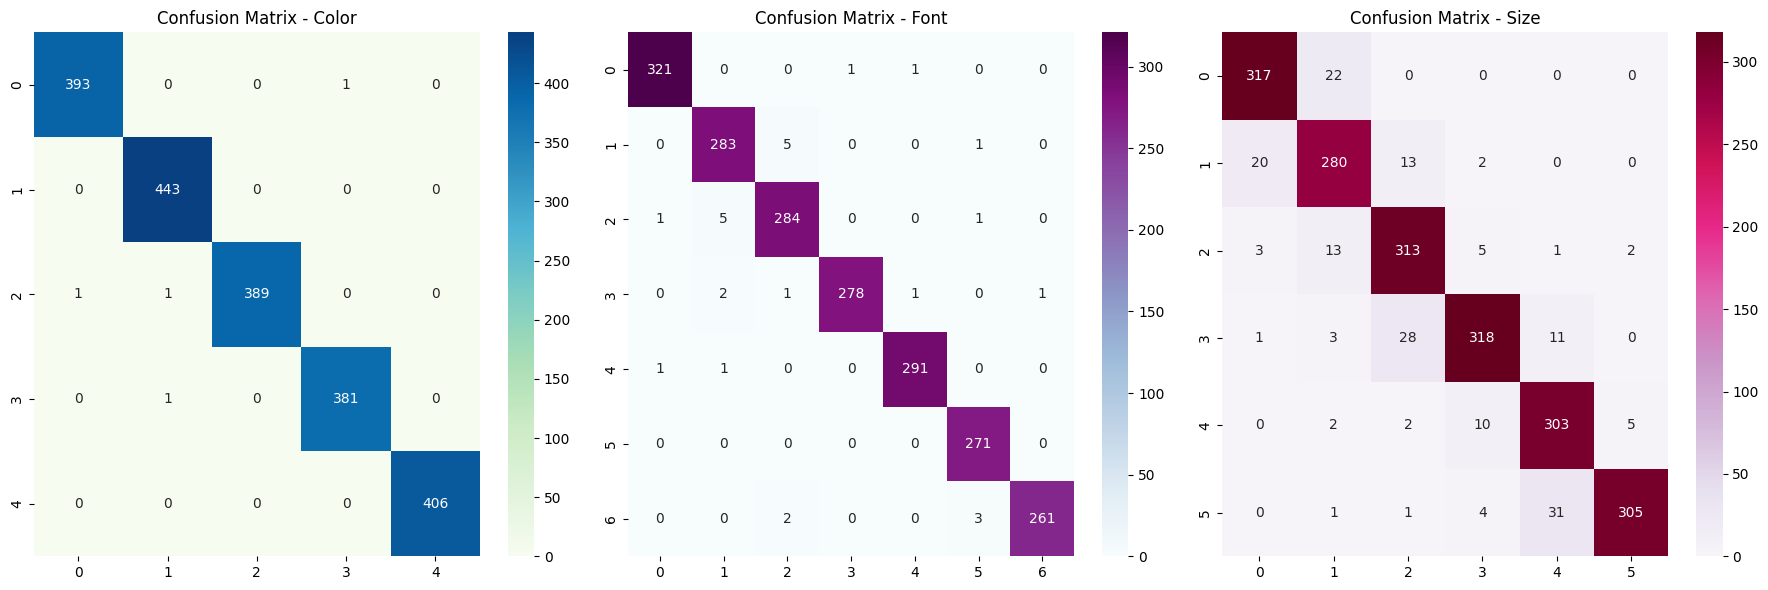

In [59]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
sns.heatmap(conf_matrix_color, annot=True, fmt='d', cmap='GnBu')
plt.title('Confusion Matrix - Color')

plt.subplot(132)
sns.heatmap(conf_matrix_font, annot=True, fmt='d', cmap='BuPu')
plt.title('Confusion Matrix - Font')

plt.subplot(133)
sns.heatmap(conf_matrix_size, annot=True, fmt='d', cmap='PuRd')
plt.title('Confusion Matrix - Size')

print("Classification Report - Color:\n", report_color)
print("Classification Report - Font:\n", report_font)
print("Classification Report - Size:\n", report_size)

plt.tight_layout()
plt.show()

In [38]:
model = CustomVGG16(h_dims_color=[256, 128], h_dims_font=[1024, 512, 256],h_dims_size=[3072, 1024, 512])
model.load_state_dict(torch.load("/content/checkpoint.pth"))

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

file_names, font_preds, size_preds, color_preds = [], [], [], []

submit_transform  = transforms.Compose([
    transforms.CenterCrop( (40,360)),
    Sharpen(),
    transforms.ColorJitter(contrast=0.1),
    transforms.ToTensor(),
    ])

csv_file = '/content/test.csv'
df = pd.read_csv(csv_file)

file_paths_from_csv = df.iloc[:, 0]

reverse_color_mapping = {v: k for k, v in dataset.color_mapping.items()}
reverse_font_mapping = {v: k for k, v in dataset.font_mapping.items()}
reverse_font_size_mapping = {v: k for k, v in dataset.font_size_mapping.items()}

with torch.no_grad():
    submit_bar = tqdm(file_paths_from_csv, desc=f'📄 Submitting...', unit='image')
    for img_path in submit_bar:

        if not os.path.exists(img_path):
            print(f"File {img_path} does not exist.")
            continue
        image = Image.open(img_path).convert('RGB')
        image = submit_transform(image)
        image = image.unsqueeze(0).to(device)

        color_output, font_output, size_output = model(image)

        color_pred = color_output.argmax(dim=1, keepdim=True).item()
        color_preds.append(f"#{reverse_color_mapping[color_pred]}")

        font_pred = font_output.argmax(dim=1, keepdim=True).item()
        font_preds.append(reverse_font_mapping[font_pred])

        size_pred = size_output.argmax(dim=1, keepdim=True).item()
        size_preds.append(reverse_font_size_mapping[size_pred])

        file_name = os.path.basename(img_path)
        file_names.append(f"images/{file_name}")

data = list(zip(file_names, font_preds, size_preds, color_preds))
submission_df = pd.DataFrame(data, columns=['image_path', 'font', 'font_size', 'color'])

output_path = 'ans.csv'
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")

📄 Submitting...: 100%|██████████| 2520/2520 [00:19<00:00, 131.07image/s]

CSV file saved to ans.csv
